This is the code for creating a transformer model that predicts occupancy by region.

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pickle

Below are the functions used to prepare the data for the model.  
The csv file contains the following information in each row: the acces point at which it is recorded, the datetime in 15 minute intervals, and the number of connections at this access point.  
-load_data(level, location) takes in level of prediciton (ap, floor, or building), and location of prediction (name of ap, floor number or DBH)   
-create_timeline(df) takes in df and makes sure all possible 15 minute interval is in df and transforms to make sure there are no NA values. Then it subtracts all non-zero count values by when to slightly account for static devices.    
-add_features(df) adds a cyclical representation of the hour and day of the week.

In [12]:

def load_data(level, location):
    """Load CSV and rename columns"""
    csv_path = '2018Q1Q2-15min.csv'
    df = pd.read_csv(csv_path)
    df = df.rename(columns={
        'interval_begin_time': 'ds',
        'count': 'y'
    })
    df['ds'] = pd.to_datetime(df['ds'])
    df = df.sort_values('ds').reset_index(drop=True)

    if level == 'ap':
        df = df[df['ap'] == location]
    elif level == 'floor':
        df = df[df['ap'].str.contains('314' + str(location))]
    elif level == 'building':
        df = df[df['ap'].str.split('-').str[0].str[:-1] == location]
    
    df = df.groupby('ds', as_index=False)['y'].sum()
    df.to_csv('og_df.csv', index=False)
    
    return df

def create_timeline(df):
    """Fill missing 15-minute intervals, handle inactive hours and resample for static devices"""
    start_date = df['ds'].min().date()
    end_date = df['ds'].max().date()
    
    # Create complete 15-minute timeline
    full_timeline = pd.date_range(
        start=start_date,
        end=end_date + pd.Timedelta(days=1),
        freq='15min'
    )
    
    complete_df = pd.DataFrame({'ds': full_timeline})
    result = complete_df.merge(df[['ds', 'y']], on='ds', how='outer')
    
    # Fill inactive hours (10 PM - 8 AM) with 0
    result['hour'] = result['ds'].dt.hour
    inactive_hours = list(range(22, 24)) + list(range(0, 8))
    inactive_mask = result['hour'].isin(inactive_hours)
    result.loc[inactive_mask & result['y'].isna(), 'y'] = 0
    
    # Forward fill remaining gaps (max 1 hour)
    result['y'] = result['y'].fillna(0)

    #accounts for static devices
    result['y'] = result['y'].apply(lambda x: x - 1 if x > 0 else x)
    
    return result[['ds', 'y']].sort_values('ds').reset_index(drop=True)


def add_features(df):
    """Add hour and day of week features"""
    df["hour"] = df["ds"].dt.hour + df["ds"].dt.minute/60
    df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
    df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
    df["dow_sin"] = np.sin(2 * np.pi * df["ds"].dt.dayofweek / 7)
    df["dow_cos"] = np.cos(2 * np.pi * df["ds"].dt.dayofweek / 7)
    df["holiday"] = 0
    
    # df = df.drop("hour", axis=1, inplace=True)
    return df



train test split

splits data into training set and testing set. create a sequence of past 96 intervals (past 24 hours) to predict the next interval.

In [ ]:
def split_train_test(df):
    """Split data into train/test sets"""
    df["y"] = df["y"].astype(float)
    if df['ds'].max() < pd.Timestamp('2018-06-10 00:00:00'):
        df_train = df[df['ds'] < '2018-02-05 00:00:00']
        df_test = df[df['ds'] >= '2018-02-05 00:00:00']
    else:
        df_train = df[df['ds'] < '2018-06-10 00:00:00']
        df_test = df[df['ds'] >= '2018-06-10 00:00:00']
    train_start = df_train['ds'].min()
    test_start = df_test['ds'].min()
    print(train_start)
    print(test_start)

    print(f" train size: {len(df_train)}, test size: {len(df_test)}")


    feature_cols = ["y", "hour_sin", "hour_cos", "dow_sin", "dow_cos", "holiday"]

    scaler = StandardScaler()
    train_y = scaler.fit_transform(df_train[["y"]])
    test_y = scaler.transform(df_test[["y"]])
    
    train_features = df_train[["hour_sin", "hour_cos", "dow_sin", "dow_cos", "holiday"]].to_numpy()
    test_features = df_test[["hour_sin", "hour_cos", "dow_sin", "dow_cos", "holiday"]].to_numpy()

    # Combine into one array
    train = np.hstack([train_y, train_features])
    test = np.hstack([test_y, test_features])

    print(len(train))
    print(len(test))


    SEQUENCE_SIZE = 96

    def to_sequences(seq_size, obs, t_start):
        x = []
        y = []
        time = []
        for i in range(len(obs) - seq_size):
            window = obs[i:(i + seq_size)]
            after_window = obs[i + seq_size, 0]
            x.append(window)
            y.append(after_window)
            time.append(t_start + pd.Timedelta(minutes=15*(seq_size+i)))
        x = np.array(x)
        y = np.array(y)
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32).view(-1, 1), time

    x_train, y_train, train_time = to_sequences(SEQUENCE_SIZE, train, train_start)
    x_test, y_test, test_time = to_sequences(SEQUENCE_SIZE, test, test_start)

    print(x_train.shape, y_train.shape)
    print(x_test.shape, y_test.shape)
    
    print(f"Training: {len(train)} points | Test: {len(test)} points")
    # print(f"Train period: {train_time.min()} to {train_time.max()}")
    # print(f"Test period: {test['ds'].min()} to {test['ds'].max()}")
    
    return x_train, y_train, train_time, x_test, y_test, test_time, scaler




Transformer model creation  
input_dim_ -> 1, d_model -> 64, heads -> 4, num_layers -> 2, dropout -> 0.2

In [14]:
# Positional Encoding for Transformer
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)
    
# Model definition using Transformer
class TransformerModel(nn.Module):
    def __init__(self, input_dim=1, d_model=64, nhead=4, num_layers=2, dropout=0.2):
        super(TransformerModel, self).__init__()

        self.encoder = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.decoder = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.encoder(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = self.decoder(x[:, -1, :])
        return x
    
    


In [23]:
def plot_predictions(predictions, actual_values, actual_dates, level, location, save_path=None):

    rmse = np.sqrt(mean_squared_error(actual_values, predictions))
    mae = mean_absolute_error(actual_values, predictions)

    # Create the plot
    plt.figure(figsize=(15, 8))
    plt.plot(actual_dates, actual_values, 'g-', linewidth=2, alpha=0.6, label='Actual')
    plt.plot(actual_dates, predictions, 'r-', linewidth=2.5, alpha=1.0, label='Predicted', zorder=10)
    
    # Title, labels, grid
    title = f'{level} {location}\nTransformer Model Test Results: Actual vs Predicted\nRMSE: {rmse:.4f}, MAE: {mae:.4f}'
    
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Number of Connections')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks()
    plt.tight_layout()
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Test comparison plot saved to: {save_path}")
    plt.show()


level can be equal to 'ap', 'floor', 'building'  
location is dependent on level  
'ap':  
"3141-clwa-1100", "3141-clwa-1412", "3141-clwa-1431", "3141-clwa-1433", "3141-clwb-1100", "3141-clwc-1100", "3141-clwd-1100", "3141-clwe-1100", "3142-clwa-2019", "3142-clwa-2039", "3142-clwa-2051", "3142-clwa-2059", "3142-clwa-2065", "3142-clwa-2099", "3142-clwa-2209", "3142-clwa-2219", "3142-clwa-2231", "3143-clwa-3019", "3143-clwa-3039", "3143-clwa-3051", "3143-clwa-3059", "3143-clwa-3065", "3143-clwa-3099", "3143-clwa-3209", "3143-clwa-3219", "3143-clwa-3231", "3144-clwa-4019", "3144-clwa-4039", "3144-clwa-4051", "3144-clwa-4059", "3144-clwa-4065", "3144-clwa-4099", "3144-clwa-4209", "3144-clwa-4219", "3144-clwa-4231", "3145-clwa-5019", "3145-clwa-5039", "3145-clwa-5051", "3145-clwa-5059", "3145-clwa-5065", "3145-clwa-5099", "3145-clwa-5209", "3145-clwa-5219", "3145-clwa-5231", "3146-clwa-6011", "3146-clwa-6029", "3146-clwa-6049", "3146-clwa-6122", "3146-clwa-6131", "3146-clwa-6217", "3146-clwa-6219"  

'floor':  
1, 2, 3, 4, 5, 6  
  
'building':   
'DBH'  

In [15]:
level = 'floor'
location = 1 

print("load data")
df = load_data(level, location)
df = create_timeline(df)
df = add_features(df)
df.to_csv('transf_df.csv', index=False)


df.head()

load data


,ds,y,hour,hour_sin,hour_cos,dow_sin,dow_cos,holiday
0,2017-12-25 00:00:00,2.0,0.00,0.000000,1.000000,0.0,1.0,0
1,2017-12-25 00:15:00,2.0,0.25,0.065403,0.997859,0.0,1.0,0
2,2017-12-25 00:30:00,2.0,0.50,0.130526,0.991445,0.0,1.0,0
3,2017-12-25 00:45:00,1.0,0.75,0.195090,0.980785,0.0,1.0,0
4,2017-12-25 01:00:00,3.0,1.00,0.258819,0.965926,0.0,1.0,0


In [20]:
print('split train_test')
x_train, y_train, train_time, x_test, y_test, test_time, scaler = split_train_test(df)

# Setup data loaders for batch
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print('creating model....')
model = TransformerModel(input_dim=x_train.shape[2])
print('model created')


split train_test
2017-12-25 00:00:00
2018-02-05 00:00:00
4032
577
4032
577
torch.Size([3936, 96, 6]) torch.Size([3936, 1])
torch.Size([481, 96, 6]) torch.Size([481, 1])
Training: 4032 points | Test: 577 points
creating model....
model created


In [21]:
# Train the model
print('training model......')
criterion = nn.MSELoss()#reduction='none')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3)

epochs = 10 #1000
early_stop_count = 0
min_val_loss = float('inf')

for epoch in range(epochs):
    model.train()
    for batch in train_loader:
        x_batch, y_batch = batch

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        # loss = (loss * (1 + 0.5 * y_batch)).mean()
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in test_loader:
            x_batch, y_batch = batch
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            # loss = (loss * (1 + 0.5 * y_batch)).mean()

            val_losses.append(loss.item())

    val_loss = np.mean(val_losses)
    scheduler.step(val_loss)

    if val_loss < min_val_loss:
        min_val_loss = val_loss
        early_stop_count = 0
    else:
        early_stop_count += 1

    if early_stop_count >= 5:
        print("Early stopping!")
        break
    print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss:.4f}")

print("training done")


training model......
Epoch 1/10, Validation Loss: 0.3402
Epoch 2/10, Validation Loss: 0.3452
Epoch 3/10, Validation Loss: 0.2922
Epoch 4/10, Validation Loss: 0.2970
Epoch 5/10, Validation Loss: 0.3023
Epoch 6/10, Validation Loss: 0.3247
Epoch 7/10, Validation Loss: 0.3042
Early stopping!
training done


evaluating......
Score (RMSE): 119.3774
time_period length: 481
predictions length 481
actuals length 481


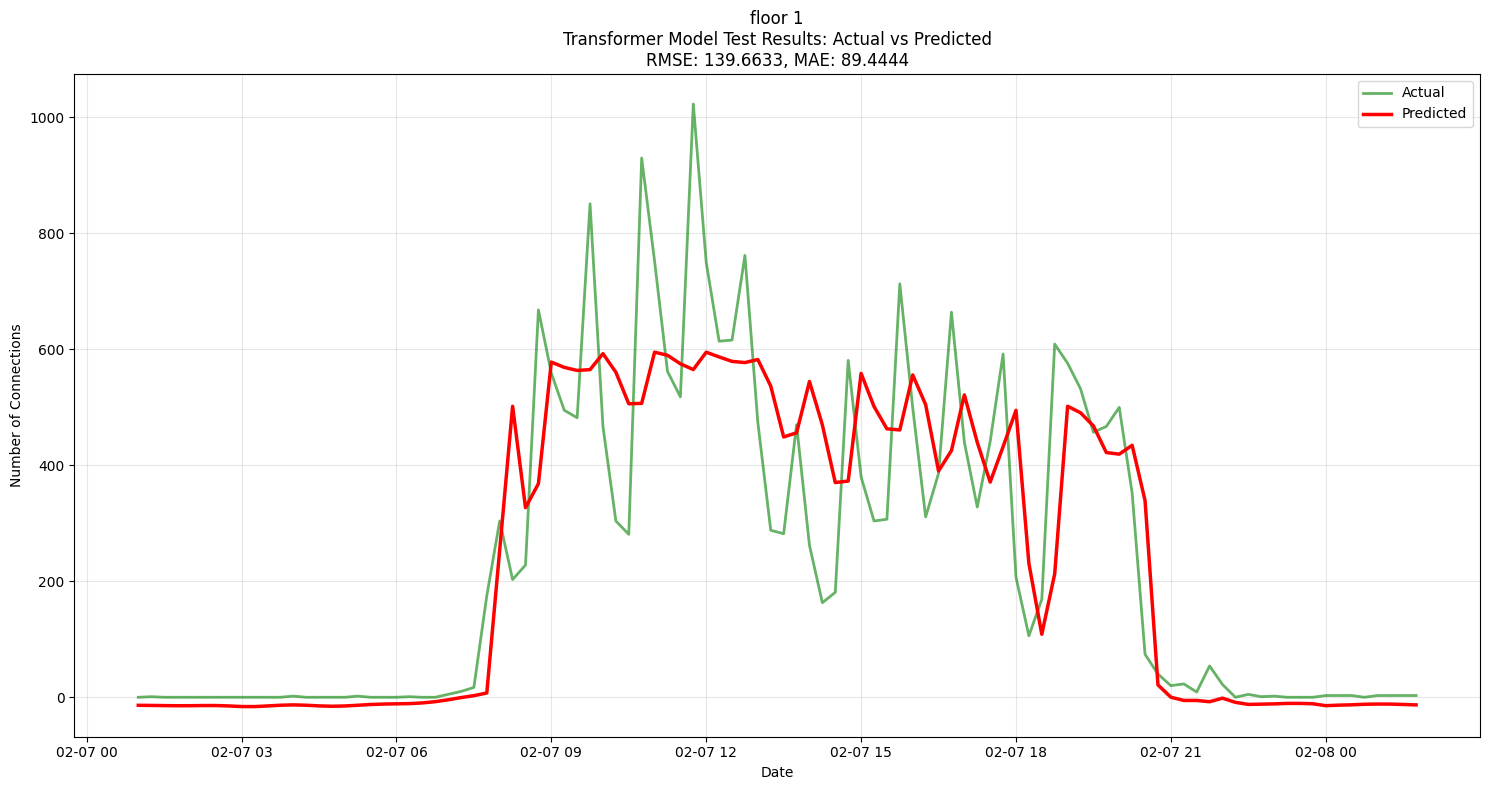

In [ ]:
# location = "3141-clwa-1431"
# with open('occupancy_transformer_models/transformer_floor'+str(location)+'.pkl', "rb") as file:
#     model = pickle.load(file)

def evaluate(model, test_loader, scaler):
    # Evaluation
    print("evaluating......")
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch in test_loader:
            x_batch, y_batch = batch
            outputs = model(x_batch)
            # print(outputs.shape)
            out = outputs.squeeze()
            if out.ndim == 0:  # single value
                predictions.append(out.item())
            else:
                predictions.extend(out.tolist())
            # predictions.extend(outputs.squeeze().tolist())
        
        
    predictions_unscaled = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    actuals_unscaled = scaler.inverse_transform(y_test.numpy().reshape(-1, 1))

    rmse = np.sqrt(np.mean((scaler.inverse_transform(np.array(predictions).reshape(-1, 1)) - scaler.inverse_transform(y_test.numpy().reshape(-1, 1)))**2))

    print(f"Score (RMSE): {rmse:.4f}")


    print("time_period length:", len(test_time))
    print("predictions length", len(predictions_unscaled))
    print("actuals length", len(actuals_unscaled))
    # predictions_unscaled[0] = predictions_unscaled[0][0]
    # print(type(predictions_unscaled[0][0]))
    # for i in range(0, len(test_time)):
    #     predictions_unscaled[i] = predictions_unscaled[i][0]
    #     actuals_unscaled[i] = actuals_unscaled[i][0]
    preds_df = pd.DataFrame(list(zip(test_time, predictions_unscaled, actuals_unscaled)), columns=['time', 'predicted num conns', 'actual num conns'])


    plot_predictions(predictions_unscaled[100:200], actuals_unscaled[100:200], test_time[100:200], level, location)
    return preds_df

preds = evaluate(model, test_loader, scaler)

In [32]:
preds

,time,predicted num conns,actual num conns
0,2018-02-06 00:00:00,[-3.7193747188905633],[5.9999957]
1,2018-02-06 00:15:00,[-0.5839279846613721],[5.0000033]
2,2018-02-06 00:30:00,[-1.2184517028307198],[5.9999957]
3,2018-02-06 00:45:00,[-1.1072126905856834],[5.9999957]
4,2018-02-06 01:00:00,[-1.3694835835650423],[3.0000033]
...,...,...,...
476,2018-02-10 23:00:00,[-3.9193950085658855],[-4.359654e-06]
477,2018-02-10 23:15:00,[-4.49687243477365],[-4.359654e-06]
478,2018-02-10 23:30:00,[-5.1190956248062776],[-4.359654e-06]
479,2018-02-10 23:45:00,[-5.737604143337222],[-4.359654e-06]


In [ ]:
with open(f'occupancy_transformer_models/transformer_{location}{level}.pkl', 'wb') as f:
    pickle.dump(model, f)
with open(f'occupancy_transformer_models/transformer_{location}{level}scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

Use this function to turn predictions into binary values

In [ ]:
def make_binary(forecast):
    forecast['time'] = pd.to_datetime(forecast['time'])
    for i in range(len(forecast)):
        if forecast.loc[i, 'predicted num conns'] > 2:
            forecast.loc[i, 'predicted num conns'] = 1
        else:
            forecast.loc[i, 'predicted num conns'] = 0
        
        if forecast.loc[i, 'actual num conns'] > 2:
            forecast.loc[i, 'actual num conns'] = 1
        else:
            forecast.loc[i, 'actual num conns'] = 0
    return forecast

binary_preds = make_binary(preds)
